# Generation of Technical Dodumentation for Products using  Gemini Multimodal

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/agents/research-multi-agents/intro_research_multi_agents_gemini_2_0.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fagents%2Fresearch-multi-agents%2Fintro_research_multi_agents_gemini_2_0.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/agents/research-multi-agents/intro_research_multi_agents_gemini_2_0.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/agents/research-multi-agents/intro_research_multi_agents_gemini_2_0.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>


#Business Value:
*   Faster Releases: Reduced time-to-market due to accelerated documentation.
*   Lower Costs: Reduced manual labor and elimination of tedious transcription/formatting.
*Improved Consistency: Accurate and up-to-date documentation is ensured.
*Enhanced Knowledge: Centralized, accessible documentation.


#Future enhancements:
This Colab demonstrates a few steps on how to use Gemini Multimodal to generate documents from product videos, using a simple template format. This process can be enhanced and scaled using an agentic framework by adding custom templates and automating the workflow.



#Architecture
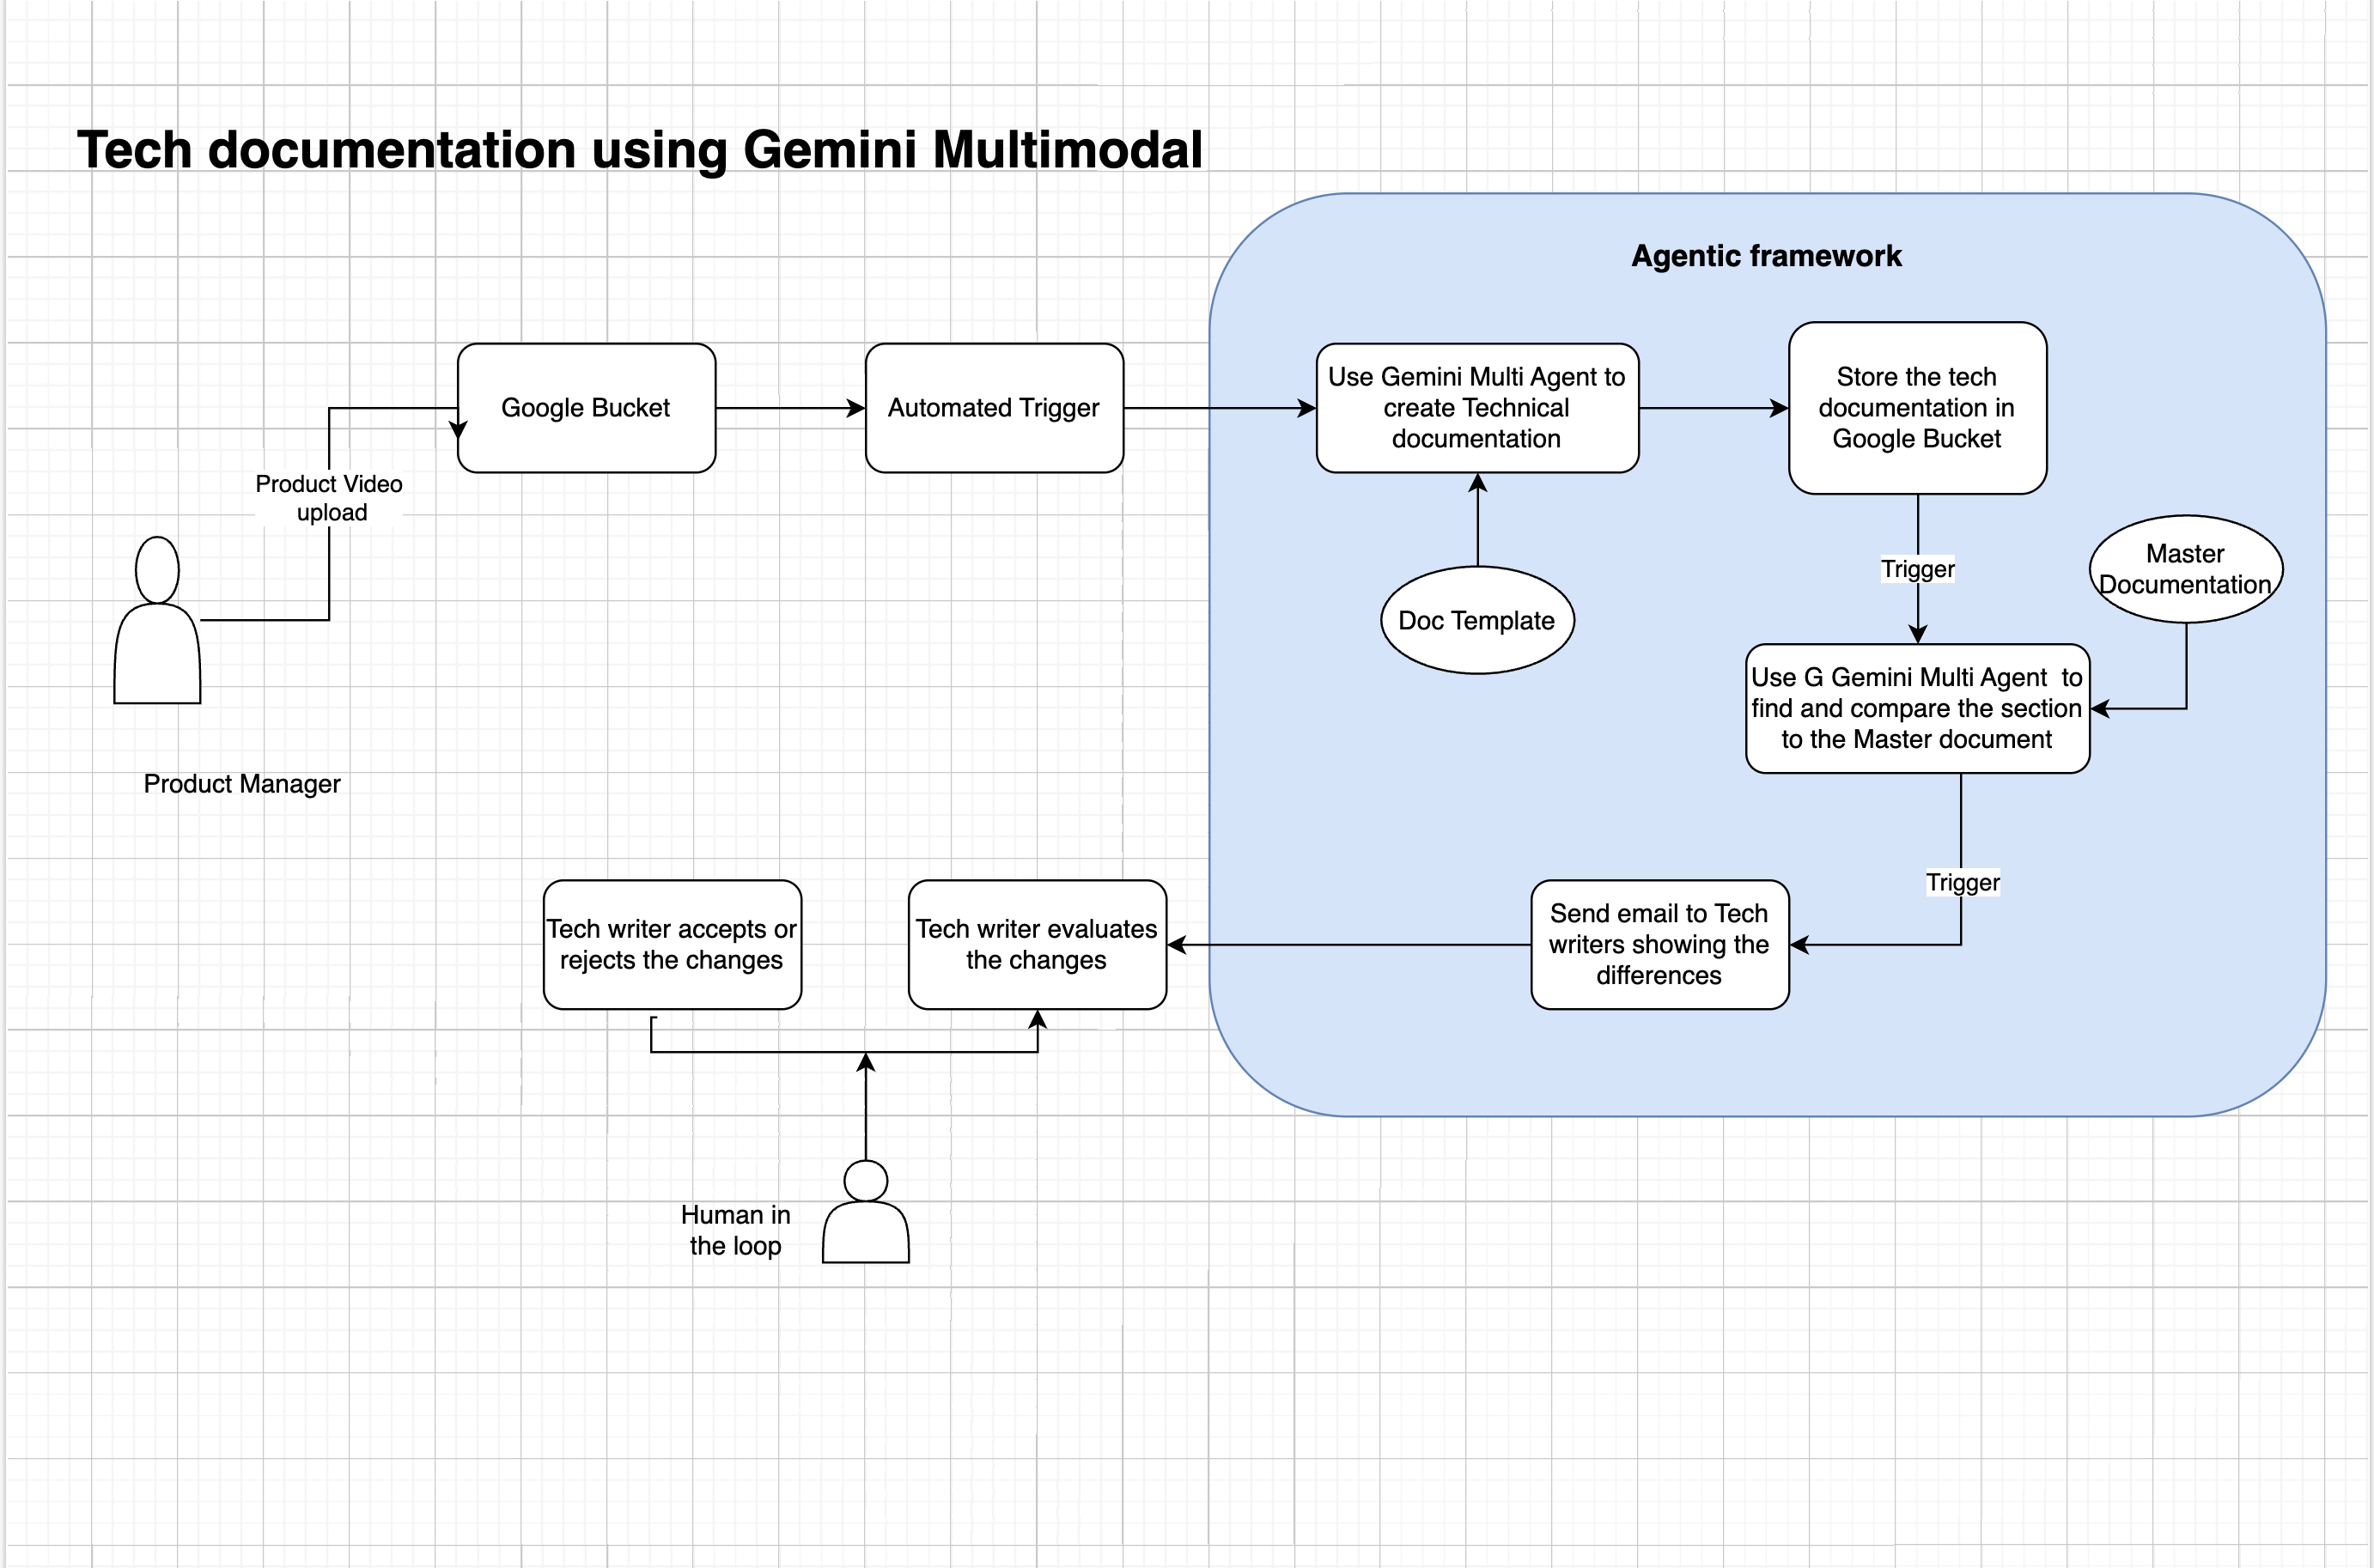

## Getting Started


### Install Vertex AI SDK for Python

In [ ]:
%pip install --upgrade --user -q google-cloud-aiplatform
%pip install markdown
%pip install pdfkit
%pip install reportlab
%pip install PyPDF2
%pip install bs4

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
# Define project information
PROJECT_ID = "Example project"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [ ]:
from IPython.display import Markdown, Video, display
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
)

### Load the Gemini 2.0 model

Gemini 2.0 is a multimodal model that supports multimodal prompts. You can include text, image(s), PDFs, audio, and video in your prompt requests and get text or code responses.

In [ ]:
# model = GenerativeModel("gemini-2.0-flash")
model = GenerativeModel("gemini-2.0-pro-exp-02-05")

generation_config = GenerationConfig(temperature=.5, top_p=0.95, max_output_tokens=8192)

safety_settings = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

### Helper functions

In [ ]:
def get_url_from_gcs(gcs_uri: str) -> str:
    # converts GCS uri to url for display.
    return gcs_uri.replace("gs://", "https://storage.googleapis.com/").replace(
        " ", "%20"
    )

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet,ParagraphStyle
from reportlab.lib.units import inch
import io
import markdown
from reportlab.pdfgen import canvas
from PyPDF2 import PdfReader, PdfWriter

def convert_gemini_response_to_pdf(response_text, filename="gemini_response.pdf", append=False):
    """
    Converts a Gemini response text into a PDF file.

    Args:
        response_text (str): The text content from the Gemini response.
        title (str, optional): The title of the PDF document. Defaults to "Gemini Response".
        filename (str, optional): The name of the output PDF file.
            Defaults to "gemini_response.pdf".
    """

    if append:
        # Read the existing PDF
        existing_pdf = PdfReader(filename)
        output = PdfWriter()
        for page in existing_pdf.pages:
            output.add_page(page)

        # Create a buffer for the new content
        buffer = io.BytesIO()
        doc = SimpleDocTemplate(buffer, pagesize=letter)
        elements = []
        # Get the styles.
        styles = getSampleStyleSheet()
        # Define a 'normal' style if it doesn't exist
        if 'normal' not in styles:
          styles.add(ParagraphStyle('normal', parent=styles['Normal']))
        # Add the title as a heading.
        elements.append(Spacer(1, 0.2 * inch))
        html_content = markdown.markdown(response_text)
        paragraphs = html_content.splitlines()
        for paragraph_text in paragraphs:
            elements.append(Paragraph(paragraph_text, styles['normal']))
            elements.append(Spacer(1, 0.1 * inch))
        doc.build(elements)

        # Add the new content to the existing PDF
        new_pdf = PdfReader(buffer)
        output.append(new_pdf)

        # Write the combined PDF to the output file
        with open(filename, "wb") as output_stream:
            output.write(output_stream)
        print(f"Gemini response appended to existing PDF: {filename}")


    else:

      # Create a buffer to hold the PDF data.
      buffer = io.BytesIO()

      # Create the PDF document using SimpleDocTemplate.
      doc = SimpleDocTemplate(buffer, pagesize=letter)

      # Create a list of flowable elements.
      elements = []

      # Get the styles.
      styles = getSampleStyleSheet()
      # Define a 'normal' style if it doesn't exist
      if 'normal' not in styles:
          styles.add(ParagraphStyle('normal', parent=styles['Normal']))

      # Add the title as a heading.
      elements.append(Spacer(1, 0.2 * inch))  # Add a small space after the title.

      # Convert Markdown to HTML, then to PDF
      html_content = markdown.markdown(response_text)  # Convert Markdown to HTML
      paragraphs = html_content.splitlines()

      for paragraph_text in paragraphs:
          #  Paragraph expects plain text, so we pass the whole html and use style normal.
          elements.append(Paragraph(paragraph_text, styles['normal']))
          elements.append(Spacer(1, 0.1 * inch))

      # Build the PDF document.
      doc.build(elements)

      # Write the PDF data to a file.
      with open(filename, "wb") as f:
          f.write(buffer.getvalue())
      print(f"PDF file created: {filename}")

## Using a prompt and the Video uploads from GCS have Gemini create a technical documentation for the Video that was created to show case the new feature.

This can be expanded to capture images from the video to show case the steps.



In [ ]:
video_analysis_prompt = """You are Technical writer and your job is to create setp wise instructions using the video input. Start with the format of Title which should be highlighted and step wise detailed instructions, also provide any trouble shooting instrucations if possible.   Create detailed Technical documentation  based on the video. Do not include preamble in your respond like Okay I can do this or what this document or ure, here's the technical documentation"""


In [ ]:
# Load file directly from Google Cloud Storage
video_uri = "gs://video-files-demo/forgot_password_demo.mov"

# Load contents
contents = [
    Part.from_uri(
        uri=video_uri,
        mime_type="video/mov",
    ),
    video_analysis_prompt,
]

# Display the Video
display(Video(get_url_from_gcs(video_uri)))

In [ ]:
# Send to Gemini
import markdown

response = model.generate_content(contents, generation_config=generation_config)

# Display results
display(Markdown(response.text))
# html_content = markdown.markdown(response.text)
# print(html_content)


In [ ]:
convert_gemini_response_to_pdf(response.text, filename="Demo_EHR_documentation.pdf", append=False )

# This next step show cases the appending of a new Tech documentation to the existing document.

In [ ]:
# Load file directly from Google Cloud Storage
video_uri = "gs://video-files-demo/checking patient medication.mov"

# Load contents
contents = [
    Part.from_uri(
        uri=video_uri,
        mime_type="video/mov",
    ),
    video_analysis_prompt,
]

# Display the Video
display(Video(get_url_from_gcs(video_uri)))

In [ ]:
# Send to Gemini
import markdown

response = model.generate_content(contents, generation_config=generation_config)

# Display results
display(Markdown(response.text))
# html_content = markdown.markdown(response.text)
# print(html_content)


In [ ]:
convert_gemini_response_to_pdf(response.text,  filename="Demo_EHR_documentation.pdf",append=True)

In [ ]:
!ls -l
!gcloud storage cp Demo_EHR_documentation.pdf gs://video-files-demo/
